In [101]:
# ...existing code...
import pandas as pd

In [102]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [103]:
df = pd.read_csv('C:/Users/USER/OneDrive/Desktop/pandas-data-analysis-main/fraud.csv')

In [104]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

#한국어로 변경

In [105]:
col_map = {
    'trans_date_trans_time': '거래일시',
    'cc_num': '카드번호',
    'merchant': '가맹점명',
    'category': '카테고리',
    'amt': '거래금액',
    'first': '이름',
    'last': '성',
    'gender': '성별',
    'street': '주소',
    'city': '도시',
    'state': '주',
    'zip': '우편번호',
    'lat': '위도',
    'long': '경도',
    'city_pop': '도시인구',
    'job': '직업',
    'dob': '생년월일',
    'trans_num': '거래번호',
    'unix_time': '유닉스시간',
    'merch_lat': '가맹점위도',
    'merch_long': '가맹점경도',
    'is_fraud': '사기여부'
}
df = df.rename(columns=col_map)


In [106]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   거래일시    491134 non-null  object 
 1   카드번호    491134 non-null  int64  
 2   가맹점명    491134 non-null  object 
 3   카테고리    491134 non-null  object 
 4   거래금액    491134 non-null  float64
 5   이름      491134 non-null  object 
 6   성       491134 non-null  object 
 7   성별      491134 non-null  object 
 8   주소      491134 non-null  object 
 9   도시      491134 non-null  object 
 10  주       491134 non-null  object 
 11  우편번호    491134 non-null  int64  
 12  위도      491134 non-null  float64
 13  경도      491134 non-null  float64
 14  도시인구    491134 non-null  int64  
 15  직업      491134 non-null  object 
 16  생년월일    491134 non-null  object 
 17  거래번호    491134 non-null  object 
 18  유닉스시간   491134 non-null  int64  
 19  가맹점위도   491134 non-null  float64
 20  가맹점경도   491134 non-null  float64
 21  사기여부    49

In [107]:
df.columns

Index(['거래일시', '카드번호', '가맹점명', '카테고리', '거래금액', '이름', '성', '성별', '주소', '도시',
       '주', '우편번호', '위도', '경도', '도시인구', '직업', '생년월일', '거래번호', '유닉스시간', '가맹점위도',
       '가맹점경도', '사기여부'],
      dtype='object')

In [108]:
drop_cols = [
    '이름', '성', '주소', '도시', '주', '우편번호',
    '직업',  '유닉스시간'
]

In [109]:

df['log_amt'] = np.log1p(df['거래금액'])
df['is_high_amount'] = (df['거래금액'] > 5000).astype(int)

In [110]:
#df['distance'] = np.sqrt(
 #   (df['lat'] - df['merch_lat'])**2 + 
#  (df['long'] - df['merch_long'])**2)

- 지금 위의 거리 계산은 평면도에서의 계산이어서 오류가 있을 수 있음 
- 위도, 경도는 구면 좌표라 실제 거리와 차이가 큼 
- 특히 위도에 따라 longitude 1도 길이가 달라짐 
- Haversine formula(하버사인 공식)
- 위도/경도는 도(degree) 단위 → 삼각함수(sin, cos) 쓰려면 라디안(radian) 로 변환
- 두 지점 사이의 Δ(latitude), Δ(longitude) 계산

In [111]:
import numpy as np

R = 6371  # 지구 반지름(km)

lat1 = np.radians(df['위도'])
lon1 = np.radians(df['경도'])
lat2 = np.radians(df['가맹점위도'])
lon2 = np.radians(df['가맹점경도'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))

df['하버사인_km'] = R * c

## 2단계. 거리 기반 파생변수 만들기 

In [112]:
# 10km 이상 떨어진 거래 여부 (binary)
df['dist_over_10km'] = (df['하버사인_km'] > 10).astype(int)

# 거리 로그변환 (long tail 완화)
df['log_distance'] = np.log1p(df['하버사인_km'])

## 3단계. 고객의 생활권 중심과의 거리 
- 고객마다 평소 생활 활동 반경이 다름
- 고객이 평소 활동하던 지역과 멀면 → 비정상적 거래 가능성 많음

In [113]:
# 고객별 중심 위치
df['중심위도'] = df.groupby('이름')['위도'].transform('mean')
df['중심경도'] = df.groupby('이름')['경도'].transform('mean')

# 중심점과의 Haversine 거리
lat_c = np.radians(df['중심위도'])
lon_c = np.radians(df['중심경도'])

dlat = lat_c - lat1
dlon = lon_c - lon1

a2 = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat_c)*np.sin(dlon/2)**2
c2 = 2 * np.arcsin(np.sqrt(a2))

df['distance_from_centroid'] = R * c2

## 4단계. 거리 + 시간 결합 (속도 계산) 
- “너무 짧은 시간에 너무 먼 거리 이동” → 실제로 불가능 → 사기 가능성 높음
- 카드 사기 탐지에서 가장 강력한 Feature 중 하나
- 거래 간 이동 속도가 비정상적으로 높으면 바로 경고 가능

In [114]:
# 0. 위도/경도 타입 깨졌을 가능성이 있음 → float 강제 변환
df['위도'] = pd.to_numeric(df['위도'], errors='coerce')
df['경도'] = pd.to_numeric(df['경도'], errors='coerce')

# 1. 거래 시간 정렬
df = df.sort_values(['이름', '거래일시'])

# 2. 이전 거래 정보
df['prev_lat'] = df.groupby('이름')['위도'].shift(1)
df['prev_lon'] = df.groupby('이름')['경도'].shift(1)
df['prev_time'] = df.groupby('이름')['거래일시'].shift(1)

# 이전 좌표 float으로 강제 변환
df['prev_lat'] = pd.to_numeric(df['prev_lat'], errors='coerce')
df['prev_lon'] = pd.to_numeric(df['prev_lon'], errors='coerce')



In [115]:
# 4. 라디안 변환
lat_curr = np.radians(df['위도'])
lon_curr = np.radians(df['경도'])
lat_prev = np.radians(df['prev_lat'])
lon_prev = np.radians(df['prev_lon'])



In [116]:
# 5. 거리 계산
R = 6371
dlat = lat_curr - lat_prev
dlon = lon_curr - lon_prev

a = np.sin(dlat/2)**2 + np.cos(lat_prev)*np.cos(lat_curr)*np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))

df['move_km'] = R * c



In [117]:
# 1) 날짜형(datetime)으로 변환 (정답)
df['거래일시'] = pd.to_datetime(df['거래일시'], errors='coerce')
df['prev_time'] = pd.to_datetime(df['prev_time'], errors='coerce')

# 2) 시간 차이(분)
df['time_diff_min'] = (df['거래일시'] - df['prev_time']).dt.total_seconds() / 60

# 3) 이동 속도 (km/h)
df['speed_kmh'] = df['move_km'] / (df['time_diff_min'] / 60)

In [118]:
#문자인 값 삭제
cols_to_drop = ['dob', 'trans_num']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

In [119]:
object_cols = [
    col for col in df.select_dtypes(include='object').columns
    if col != 'trans_date_trans_time'
]
    

In [122]:

X = df.drop(['사기여부', '거래일시'], axis=1)
y = df['사기여부']

In [ ]:
# y(label) 비율이 train과 test 모두에서 동일하게 유지되도록 분리
# 사기 vs 정상 비율이 전체 데이터와 동일하게 분포되도록
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [124]:
df.columns


Index(['거래일시', '카드번호', '가맹점명', '카테고리', '거래금액', '이름', '성', '성별', '주소', '도시',
       '주', '우편번호', '위도', '경도', '도시인구', '직업', '생년월일', '거래번호', '유닉스시간', '가맹점위도',
       '가맹점경도', '사기여부', 'log_amt', 'is_high_amount', '하버사인_km',
       'dist_over_10km', 'log_distance', '중심위도', '중심경도',
       'distance_from_centroid', 'prev_lat', 'prev_lon', 'prev_time',
       'move_km', 'time_diff_min', 'speed_kmh'],
      dtype='object')

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\IPy

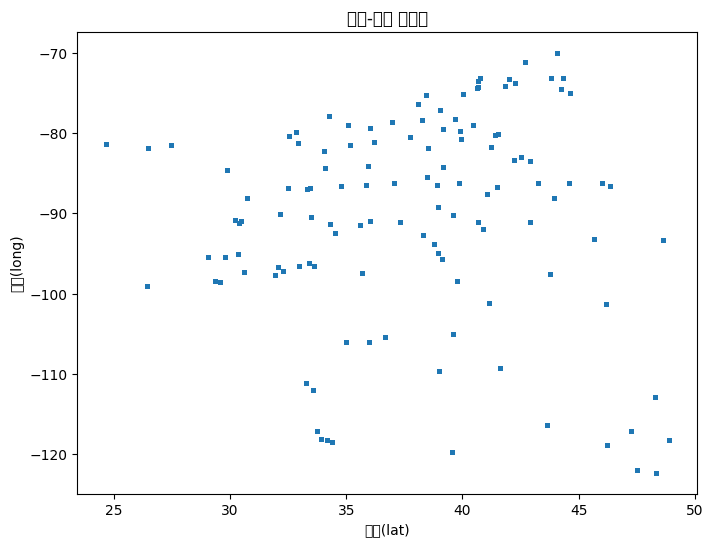

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['위도'], df['경도'], alpha=0.3, s=5)
plt.xlabel('위도(lat)')
plt.ylabel('경도(long)')
plt.title('위도-경도 산점도')
plt.show()